In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import multiprocessing
import seaborn as sns
import pickle

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora.dictionary import Dictionary
from gensim.utils import simple_preprocess

In [2]:
nltk.__version__

'3.4.5'

In [3]:
np.__version__

'1.18.1'

### Importing data and formatting

In [4]:
with open('../data/raw.json') as json_file:
    data = json.load(json_file)

In [5]:
cat_set=set()

for game in data:
    cat_set.update(game['categories'])
    
print('Number of category types: ', len(cat_set))

Number of category types:  83


In [6]:
# The below is some code I've written for my AVC class to transform the data into a suitable one-hot encoded format
df = pd.DataFrame(data)

# https://stackoverflow.com/questions/27263805/pandas-column-of-lists-create-a-row-for-each-list-element
lst_col = 'categories'

categories_split = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]

categories_one_hot = pd.get_dummies(categories_split, columns=['categories'])

id_and_categories_columns = ['id'] + list(categories_one_hot.columns[12:])

categories_collapsed = categories_one_hot[id_and_categories_columns].groupby(by='id', as_index=False).sum()

df_with_categories = df.merge(categories_collapsed, how='inner', on='id')

df_cats = df_with_categories[['id', 'name', 'description']+list(categories_one_hot.columns[12:])]

df_cats.head()

,id,name,description,categories_Abstract Strategy,categories_Action / Dexterity,categories_Adventure,categories_Age of Reason,categories_American Civil War,categories_American Indian Wars,categories_American Revolutionary War,...,categories_Transportation,categories_Travel,categories_Trivia,categories_Video Game Theme,categories_Vietnam War,categories_Wargame,categories_Word Game,categories_World War I,categories_World War II,categories_Zombies
0,174430,Gloomhaven,Gloomhaven is a game of Euro-inspired tactica...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,161936,Pandemic Legacy: Season 1,Pandemic Legacy is a co-operative campaign gam...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,182028,Through the Ages: A New Story of Civilization,Through the Ages: A New Story of Civilization ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,167791,Terraforming Mars,"In the 2400s, mankind begins to terraform the ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12333,Twilight Struggle,"""Now the trumpet summons us again, not as a ca...",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
df_cats.shape

(17147, 86)

In [8]:
# Example description
print(df_cats.description[0])

Gloomhaven  is a game of Euro-inspired tactical combat in a persistent world of shifting motives. Players will take on the role of a wandering adventurer with their own special set of skills and their own reasons for traveling to this dark corner of the world. Players must work together out of necessity to clear out menacing dungeons and forgotten ruins. In the process, they will enhance their abilities with experience and loot, discover new locations to explore and plunder, and expand an ever-branching story fueled by the decisions they make.

This is a game with a persistent and changing world that is ideally played over many game sessions. After a scenario, players will make decisions on what to do, which will determine how the story continues, kind of like a “Choose Your Own Adventure” book. Playing through a scenario is a cooperative affair where players will fight against automated monsters using an innovative card system to determine the order of play and what a player does on t

In [9]:
# Example categories for the above game of Gloomhaven
data[0]['categories']

['Adventure', 'Exploration', 'Fantasy', 'Fighting', 'Miniatures']

### Targets EDA

In [10]:
cat_cols = df_cats.columns[3:]

# Average number of categories per game
np.mean(np.sum(df_cats[cat_cols].to_numpy(), axis=1))

2.644077681227037

In [11]:
unique, counts = np.unique(np.sum(df_cats[cat_cols].to_numpy(), axis=1), return_counts=True)

<BarContainer object of 14 artists>

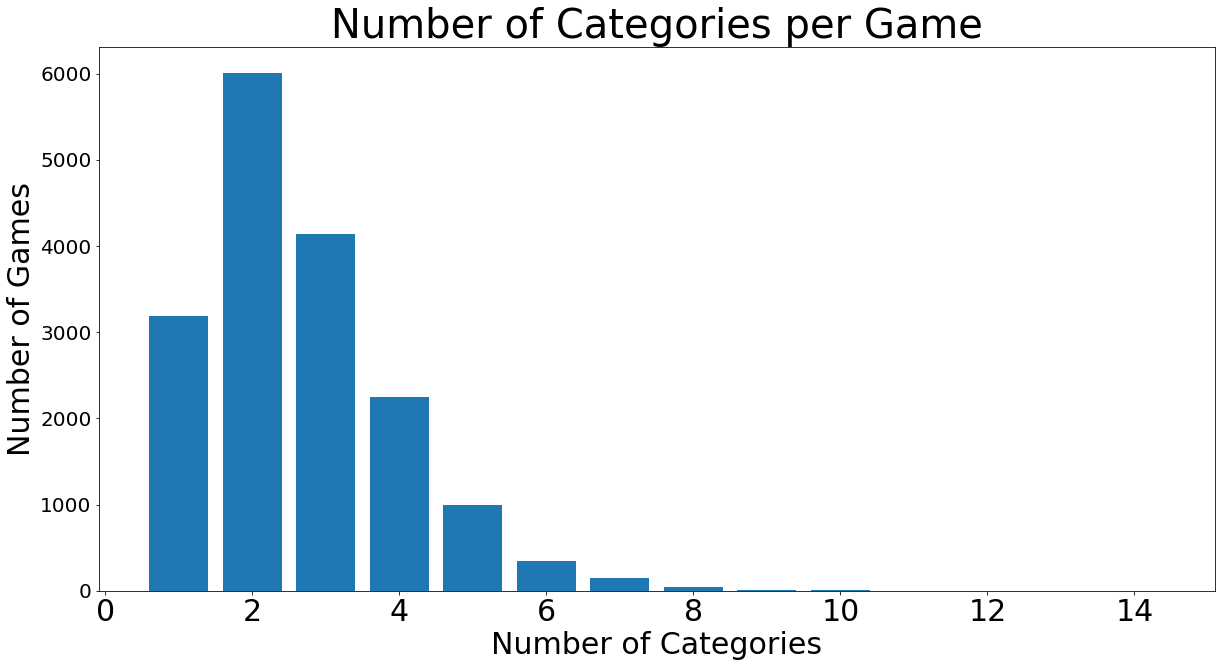

In [18]:
plt.figure(figsize=(20,10))
plt.title('Number of Categories per Game', fontsize=40)
plt.ylabel('Number of Games', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Number of Categories', fontsize=30)
plt.xticks(fontsize=30)
plt.bar(unique, counts)

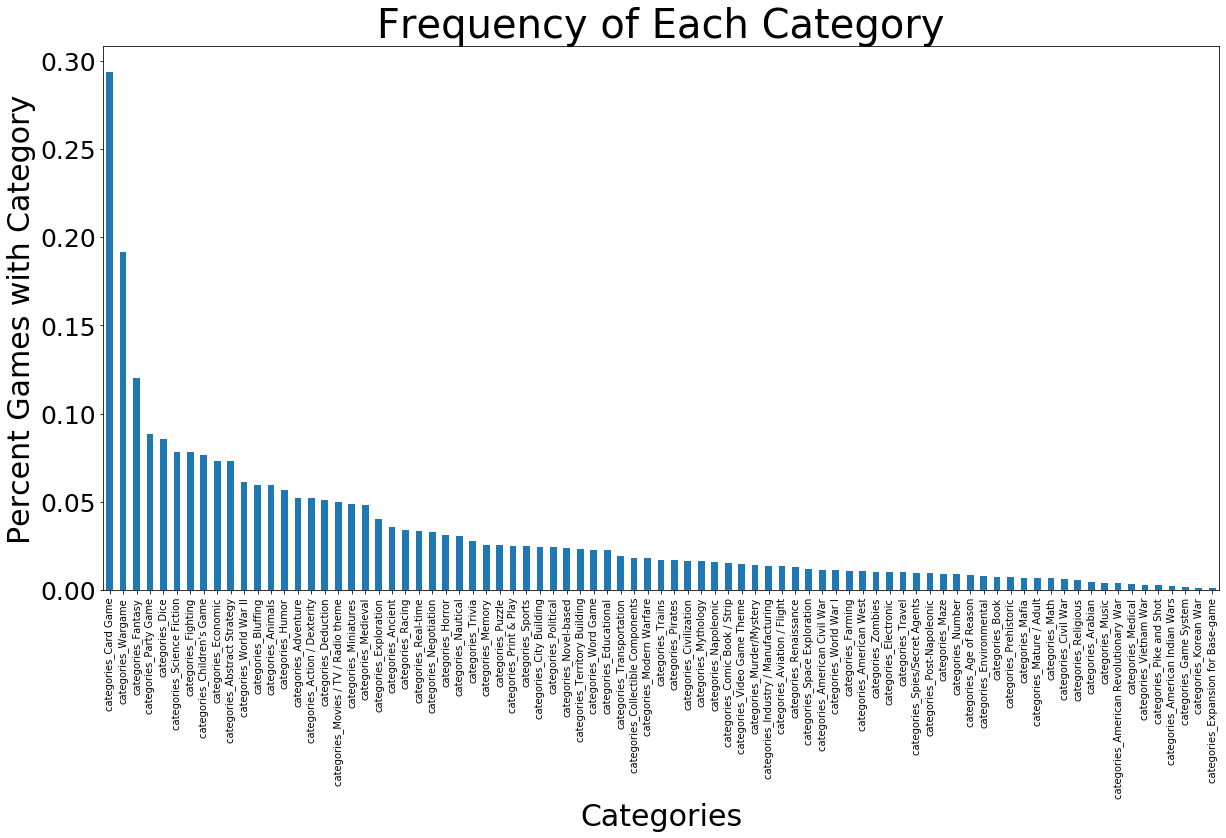

In [26]:
plt.figure(figsize=(20,10))
plt.title('Frequency of Each Category', fontsize=40)
plt.ylabel('Percent Games with Category', fontsize=30)
plt.yticks(fontsize=25)
plt.xlabel('Categories', fontsize=30)
plt.xticks(fontsize=10)
df_cats.iloc[:, 3:].mean().sort_values(ascending=False).plot.bar()

In [29]:
# There is one empty row
df_cats.drop(9820, axis=0, inplace=True)

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


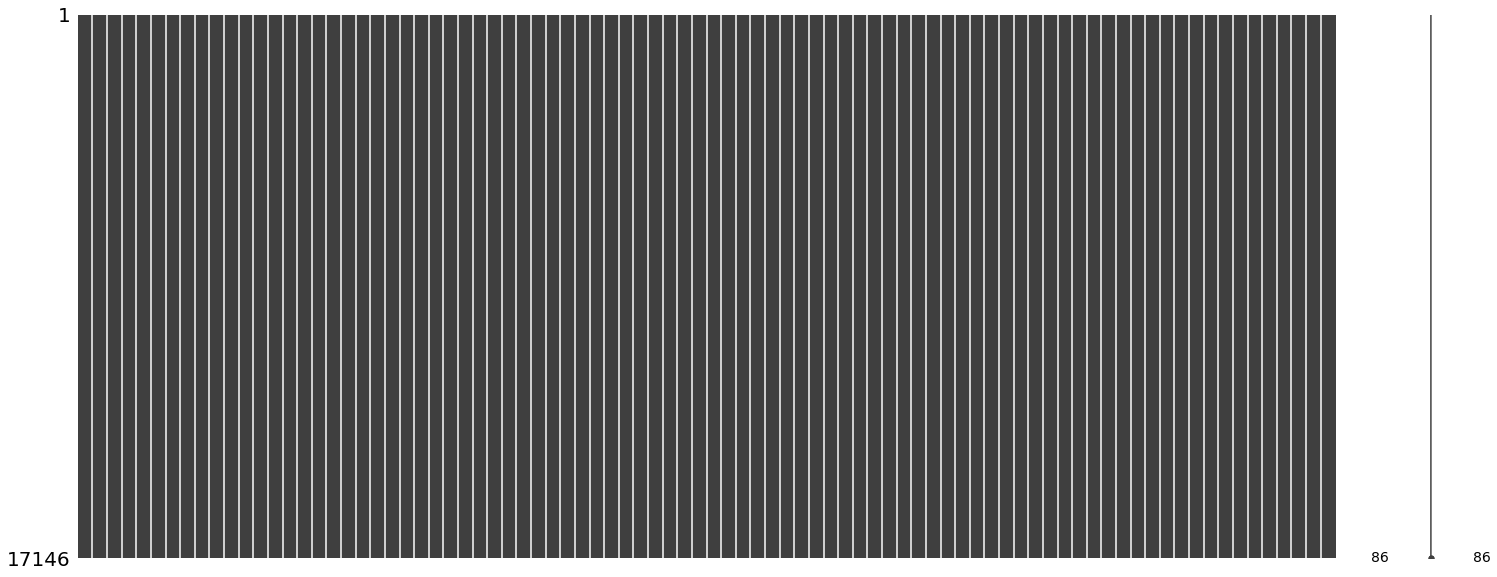

In [30]:
# Verifying there are no other missing rows
msno.matrix(df_cats)

How often do categories appear together

In [31]:
cat_cols = df_cats.columns[3:]

# Pairwise Jaccard Distance between all category columns
jacc_sim_df = pd.DataFrame(1-pairwise_distances(df_cats.loc[:,cat_cols].T.values, metric='jaccard'), index = cat_cols, columns = cat_cols)

/Users/kristiyan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


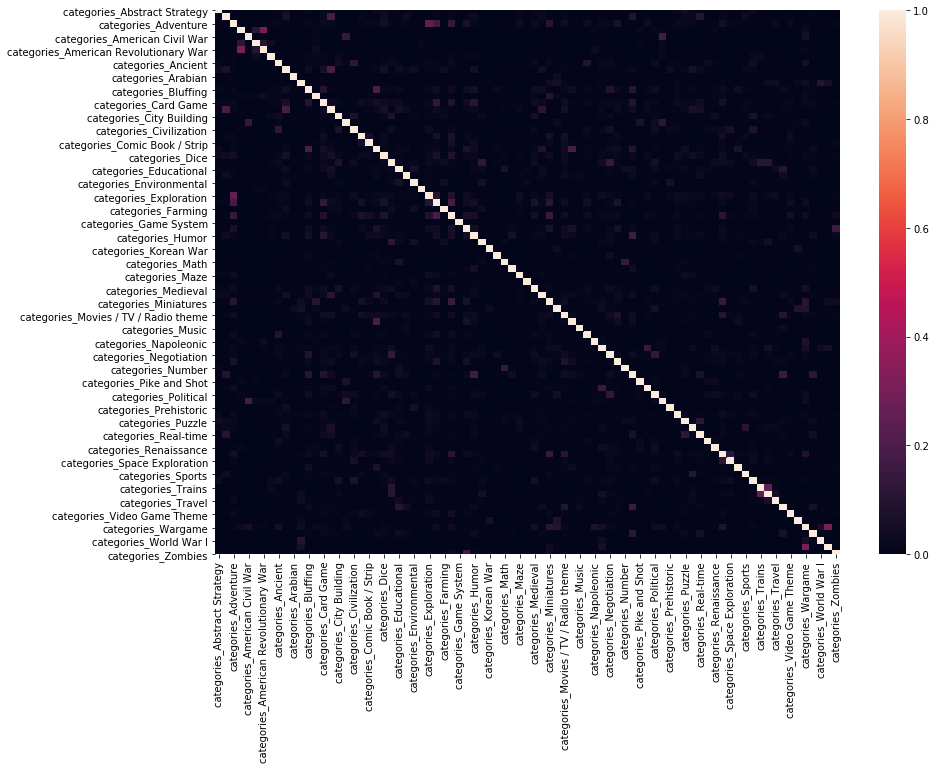

In [32]:
plt.subplots(figsize=(14,10))
sns.heatmap(jacc_sim_df)

In [33]:
df_cats.head()

,id,name,description,categories_Abstract Strategy,categories_Action / Dexterity,categories_Adventure,categories_Age of Reason,categories_American Civil War,categories_American Indian Wars,categories_American Revolutionary War,...,categories_Transportation,categories_Travel,categories_Trivia,categories_Video Game Theme,categories_Vietnam War,categories_Wargame,categories_Word Game,categories_World War I,categories_World War II,categories_Zombies
0,174430,Gloomhaven,Gloomhaven is a game of Euro-inspired tactica...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,161936,Pandemic Legacy: Season 1,Pandemic Legacy is a co-operative campaign gam...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,182028,Through the Ages: A New Story of Civilization,Through the Ages: A New Story of Civilization ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,167791,Terraforming Mars,"In the 2400s, mankind begins to terraform the ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12333,Twilight Struggle,"""Now the trumpet summons us again, not as a ca...",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Features (Descriptions) EDA & Basic Preprocessing

In [34]:
descriptions = df_cats.description.to_list()

In [35]:
tokenized_descriptions = [simple_preprocess(description) for description in descriptions]

In [36]:
desc_len = [len(tokenized_description) for tokenized_description in tokenized_descriptions]

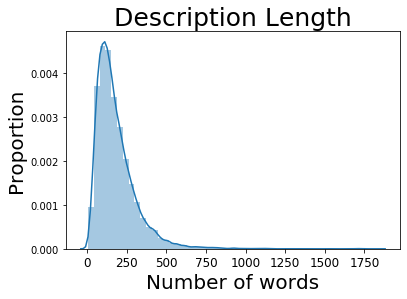

In [41]:
plt.title('Description Length', fontsize=25)
plt.ylabel('Proportion', fontsize=20)
plt.xticks(fontsize=12)
plt.xlabel('Number of words', fontsize=20)
sns.distplot(desc_len)

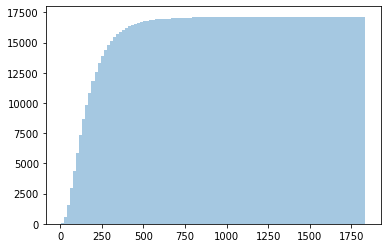

In [21]:
sns.distplot(desc_len, bins=100, hist_kws={'cumulative': True}, kde=False)

In [42]:
def remove_stopwords(tokenized_description):
    
    return [word for word in tokenized_description if word not in stopwords.words('english')]

In [43]:
# This takes a few minutes
pool=multiprocessing.Pool(multiprocessing.cpu_count())

tokenized_nostops_descriptions = pool.map(remove_stopwords, tokenized_descriptions)

pool.close()

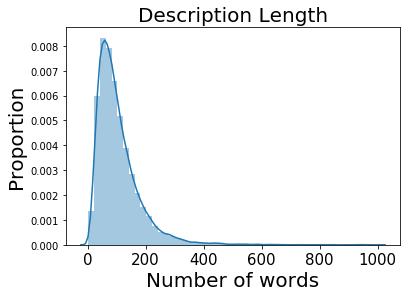

In [50]:
desc_nostops_len = [len(tokenized_description) for tokenized_description in tokenized_nostops_descriptions] 
plt.title('Description Length', fontsize=20)
plt.ylabel('Proportion', fontsize=20)
plt.xlabel('Number of words', fontsize=20)
plt.xticks(fontsize=15)
sns.distplot(desc_nostops_len)

In [45]:
print('Average Number of Description Tokens', sum(desc_nostops_len)/len(desc_nostops_len))

Average Number of Description Tokens 105.30316108713403


In [46]:
dictionary = Dictionary(tokenized_nostops_descriptions)

In [47]:
len(dictionary)

60429

In [48]:
sum(desc_nostops_len)

1805528

In [27]:
with open('gensim_dictionary.pickle', 'wb') as handle:
    pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenized_nostops_descriptions.pickle', 'wb') as handle:
    pickle.dump(tokenized_nostops_descriptions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('df_cats.pickle', 'wb') as handle:
    pickle.dump(df_cats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Appendix

In [104]:
# Alternative way to calculate pairwise jaccard scores

pairwise_jacc_sim = dict()

for ii in range(len(cat_cols)):
    print(ii)
    for kk in range(ii+1, len(cat_cols)):
        pairwise_jacc_sim[(cat_cols[ii], cat_cols[kk])] = jaccard_score(df_cats.loc[:,cat_cols[ii]], df_cats.loc[:, cat_cols[kk]])